# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [4]:
from unityagents import UnityEnvironment
import numpy as np

In [6]:
env = UnityEnvironment(file_name="C:/Users/20205231/Documents/deep-reinforcement-learning/p1_navigation/Banana_Windows_x86_64/Banana_Windows_x86_64/Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [7]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [8]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [12]:
#model

import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.bn = nn.BatchNorm1d(state_size)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(self.bn(state)))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [13]:
#agent


import numpy as np
import random
from collections import namedtuple, deque


import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
#TAU = 1              # for soft update of target parameters
LR = 1e-3              # learning rate 
#UPDATE_EVERY = 4        # how often to update the network
#UPDATE_EVERY_2=1000

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DQN():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, tau, UPDATE_EVERY,UPDATE_EVERY2, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        self.t_step2 = 0
        self.tau=tau
        self.UPDATE_EVERY=UPDATE_EVERY
        self.UPDATE_EVERY2=UPDATE_EVERY2
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        
        
        # ------------------- update target network ------------------- #
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY     
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
                
        self.t_step2 = (self.t_step2 +1) % self.UPDATE_EVERY2
        if self.t_step2 == 0:
            self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)        
            

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:

            return int(np.argmax(action_values.cpu().data.numpy()))
        else:
            return int(random.choice(np.arange(self.action_size)))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [14]:



import numpy as np
import random
from collections import namedtuple, deque


import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 1e-3              # learning rate 


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DDQN():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size,tau, UPDATE_EVERY,UPDATE_EVERY2, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        self.t_step2 = 0
        
        self.tau=tau
        self.UPDATE_EVERY=UPDATE_EVERY
        self.UPDATE_EVERY2=UPDATE_EVERY2
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        
        
        # ------------------- update target network ------------------- #
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY     
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
                
        self.t_step2 = (self.t_step2 +1) % self.UPDATE_EVERY2
        if self.t_step2 == 0:
            self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)        
            

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:

            return int(np.argmax(action_values.cpu().data.numpy()))
        else:
            return int(random.choice(np.arange(self.action_size)))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_local_action = self.qnetwork_local(next_states).detach().argmax(1).unsqueeze(1)
        #print('///////')
        #print(Q_targets_action)
        #print(self.qnetwork_local(next_states).detach())
        Q_target_next = self.qnetwork_target(next_states).gather(1, Q_local_action)
        #print(Q_local_next)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_target_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [16]:
import matplotlib.pyplot as plt


In [17]:
#train

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    num=0
    agent=DQN(state_size,action_size,1,4,1000,30)
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        done=False
        while not done:
            action = agent.act(state,eps)        # select an 
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        num=(num+1)%4
        if num==0:
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn(n_episodes=2000)



Episode 100	Average Score: 0.08
Episode 200	Average Score: 0.83
Episode 300	Average Score: 1.64
Episode 400	Average Score: 2.84
Episode 500	Average Score: 3.90
Episode 600	Average Score: 5.01
Episode 700	Average Score: 5.50
Episode 800	Average Score: 6.42
Episode 900	Average Score: 7.48
Episode 1000	Average Score: 7.01
Episode 1100	Average Score: 8.36
Episode 1200	Average Score: 8.29
Episode 1300	Average Score: 9.38
Episode 1400	Average Score: 9.58
Episode 1500	Average Score: 9.26
Episode 1600	Average Score: 10.51
Episode 1700	Average Score: 11.52
Episode 1800	Average Score: 11.20
Episode 1900	Average Score: 11.11
Episode 2000	Average Score: 11.77


In [55]:
#train with faster decay exploration

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.95):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    num=0
    agent=DQN(state_size,action_size,1,4,1000,30)
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        done=False
        while not done:
            action = agent.act(state,eps)        # select an 
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        num=(num+1)%4
        if num==0:
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores1 = dqn(n_episodes=2000)



Episode 100	Average Score: 1.62
Episode 200	Average Score: 8.63
Episode 300	Average Score: 9.85
Episode 400	Average Score: 10.99
Episode 493	Average Score: 13.04
Environment solved in 393 episodes!	Average Score: 13.04


In [60]:
#train with soft update


def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    num=0
    agent=DQN(state_size,action_size,1e-3,4,4,30)
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        done=False
        while not done:
            action = agent.act(state,eps)        # select an 
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        num=(num+1)%4
        if num==0:
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores2 = dqn(n_episodes=2000)



Episode 100	Average Score: -0.04
Episode 200	Average Score: 0.88
Episode 300	Average Score: 2.07
Episode 400	Average Score: 2.79
Episode 500	Average Score: 4.53
Episode 600	Average Score: 5.65
Episode 700	Average Score: 6.13
Episode 800	Average Score: 7.44
Episode 900	Average Score: 8.11
Episode 1000	Average Score: 8.78
Episode 1100	Average Score: 9.50
Episode 1200	Average Score: 10.36
Episode 1300	Average Score: 11.18
Episode 1400	Average Score: 11.75
Episode 1500	Average Score: 12.20
Episode 1600	Average Score: 12.11
Episode 1700	Average Score: 12.28
Episode 1800	Average Score: 12.40
Episode 1867	Average Score: 13.01
Environment solved in 1767 episodes!	Average Score: 13.01


In [62]:
#train with soft update


def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    num=0
    agent=DQN(state_size,action_size,1e-2,4,4,30)
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        done=False
        while not done:
            action = agent.act(state,eps)        # select an 
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        num=(num+1)%4
        if num==0:
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores5 = dqn(n_episodes=2000)



Episode 100	Average Score: 0.21
Episode 200	Average Score: 0.15
Episode 300	Average Score: 2.08
Episode 400	Average Score: 2.76
Episode 500	Average Score: 3.70
Episode 600	Average Score: 4.97
Episode 700	Average Score: 5.59
Episode 800	Average Score: 6.40
Episode 900	Average Score: 7.85
Episode 1000	Average Score: 8.38
Episode 1100	Average Score: 9.06
Episode 1200	Average Score: 9.814
Episode 1300	Average Score: 10.81
Episode 1400	Average Score: 11.04
Episode 1500	Average Score: 10.94
Episode 1600	Average Score: 11.46
Episode 1700	Average Score: 11.63
Episode 1800	Average Score: 12.38
Episode 1900	Average Score: 12.95
Episode 1901	Average Score: 13.02
Environment solved in 1801 episodes!	Average Score: 13.02


In [61]:
#train double dqn

def ddqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    num=0
    agent=DDQN(state_size,action_size,1,4,1000,30)
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        done=False
        while not done:
            action = agent.act(state,eps)        # select an 
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        num=(num+1)%4
        if num==0:
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores3 = ddqn(n_episodes=2000)



Episode 100	Average Score: 0.30
Episode 200	Average Score: 0.91
Episode 300	Average Score: 1.69
Episode 400	Average Score: 2.38
Episode 500	Average Score: 3.67
Episode 600	Average Score: 4.77
Episode 700	Average Score: 5.88
Episode 800	Average Score: 6.90
Episode 900	Average Score: 7.08
Episode 1000	Average Score: 8.01
Episode 1100	Average Score: 8.30
Episode 1200	Average Score: 9.76
Episode 1300	Average Score: 10.16
Episode 1400	Average Score: 11.03
Episode 1500	Average Score: 10.08
Episode 1600	Average Score: 12.25
Episode 1700	Average Score: 12.40
Episode 1800	Average Score: 12.78
Episode 1826	Average Score: 13.04
Environment solved in 1726 episodes!	Average Score: 13.04


In [63]:
#train double dqn

def ddqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    num=0
    agent=DDQN(state_size,action_size,1e-3,4,4,30)
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        done=False
        while not done:
            action = agent.act(state,eps)        # select an 
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        num=(num+1)%4
        if num==0:
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores6 = ddqn(n_episodes=2000)



Episode 100	Average Score: 0.18
Episode 200	Average Score: 0.74
Episode 300	Average Score: 1.57
Episode 400	Average Score: 3.18
Episode 500	Average Score: 4.45
Episode 600	Average Score: 5.48
Episode 700	Average Score: 6.48
Episode 800	Average Score: 7.45
Episode 900	Average Score: 8.34
Episode 1000	Average Score: 8.51
Episode 1100	Average Score: 10.02
Episode 1200	Average Score: 10.32
Episode 1300	Average Score: 11.88
Episode 1400	Average Score: 11.52
Episode 1500	Average Score: 12.05
Episode 1600	Average Score: 12.39
Episode 1700	Average Score: 12.25
Episode 1787	Average Score: 13.01
Environment solved in 1687 episodes!	Average Score: 13.01


In [53]:
BUFFER_SIZE = int(1e4)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
#TAU = 1              # for soft update of target parameters
LR = 1e-3              # learning rate 
#UPDATE_EVERY = 4        # how often to update the network
#UPDATE_EVERY_2=1000

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class PriorityReplay():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size,greedy,tau, UPDATE_EVERY,UPDATE_EVERY2, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        self.b=1

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBufferPriority(action_size, BUFFER_SIZE, BATCH_SIZE,greedy, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        self.t_step2 = 0
        
        self.tau=tau
        self.UPDATE_EVERY=UPDATE_EVERY
        self.UPDATE_EVERY2=UPDATE_EVERY2
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.qnetwork_local.eval()
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        next_state = torch.from_numpy(next_state).float().unsqueeze(0).to(device)
        Q_expected = self.qnetwork_local(state).detach().numpy()[0][action]
        Q_next = self.qnetwork_local(next_state).detach().argmax(1).unsqueeze(1).numpy()
        self.qnetwork_local.train()
        
        priority=abs(reward+Q_next-Q_expected)+1
        self.memory.add(state, action, reward, next_state, done,priority)
        

        # ------------------- update target network ------------------- #

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY     
        if self.t_step == 0:
            #self.b=self.b*0.95
            self.memory.greedy=self.memory.greedy*0.99995
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
                
        self.t_step2 = (self.t_step2 +1) % self.UPDATE_EVERY2
        if self.t_step2 == 0:
            self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)        
            

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:

            return int(np.argmax(action_values.cpu().data.numpy()))
        else:
            return int(random.choice(np.arange(self.action_size)))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones, priorities = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().argmax(1).unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = torch.sum((((1/BATCH_SIZE)*(1/priorities))**(1-self.b)) * (Q_expected- Q_targets)**2) 
        
        
        
        
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBufferPriority:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size,greedy, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done",'priority'])
        self.seed = random.seed(seed)
        self.greedy=greedy
    
    def add(self, state, action, reward, next_state, done,priority):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done,priority)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        
        summation=sum([p.priority[0]**(1-self.greedy) for p in self.memory])
        aux=[p.priority[0]**(1-self.greedy)/summation for p in self.memory]
        priority = [val for sublist in aux for val in sublist]


        index = np.random.choice(range(len(self.memory)), size=self.batch_size,p=priority)
        experiences=[self.memory[i] for i in index]

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        priorities = torch.from_numpy(np.vstack([e.priority for e in experiences if e is not None])).float().to(device)
        
        return (states, actions, rewards, next_states, dones,priorities)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [54]:
#train

def Replay(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    num=0
    agent=PriorityReplay(state_size,action_size,1,1,4,1000,30)
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        done=False
        while not done:
            action = agent.act(state,eps)        # select an 
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        num=(num+1)%4
        if num==0:
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            print('\rEpisode {}\tAverage priority: {:.2f}'.format(i_episode,agent.memory.greedy))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores4 = Replay(n_episodes=2000)

Episode 100	Average Score: 0.09
Episode 100	Average priority: 0.02
Episode 108	Average Score: 0.03

KeyboardInterrupt: 

In [69]:
import pandas

In [70]:
s = pandas.Series(scores)
scores01=np.array(s.rolling(100).mean().dropna())

s = pandas.Series(scores1)
scores11=np.array(s.rolling(100).mean().dropna())

s = pandas.Series(scores2)
scores21=np.array(s.rolling(100).mean().dropna())

s = pandas.Series(scores3)
scores31=np.array(s.rolling(100).mean().dropna())

#s = pandas.Series(scores4)
#scores41=np.array(s.rolling(100).mean().dropna())

s = pandas.Series(scores5)
scores51=np.array(s.rolling(100).mean().dropna())

s = pandas.Series(scores6)
scores61=np.array(s.rolling(100).mean().dropna())

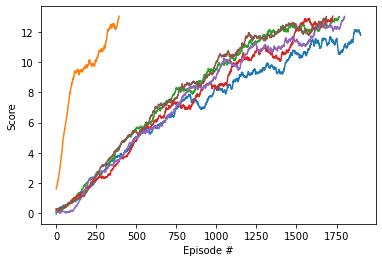

In [72]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores01)), scores01,label='Baseline')
plt.plot(np.arange(len(scores11)), scores11,label='Exploration 0.95')
plt.plot(np.arange(len(scores21)), scores21,label='Soft update 1e-3')
plt.plot(np.arange(len(scores31)), scores31,label='Double dqn')
#plt.plot(np.arange(len(scores41)), scores4,label='priority replay')
plt.plot(np.arange(len(scores51)), scores51,label='Soft update 1e-2')
plt.plot(np.arange(len(scores61)), scores61,label='Double Soft update 1e-3')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [13]:
env.close()

In [1]:
scores=[1]
scores2=[2]
scores3=[1]